In [250]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## Amiral

### TOOLS

In [217]:

#### TOOLS METHODS #########################################################

def direction_to_goal(x, y, x_g=16., y_g=31.):
    ux = x_g - x
    uy = y_g - y
    n_u = np.sqrt(ux**2 + uy**2)
    if n_u > 0:
        ux = ux / n_u
        uy = uy / n_u
        return (ux, uy)
    else:
        return (0,0)

def rosace_des_vents(x, y, x_g=16., y_g=31.):
    directions = np.zeros(9)
    dir_g = direction_to_goal(x, y, x_g=x_g, y_g=y_g)

    for action in range(0,9):
        u = actions_to_dir(action)
        dot = np.dot(u, dir_g)
        directions[action] = dot
        
    return directions

def actions_to_dir(i:int):
    if i < 0 or i >= 8:
        u = (0,0)
        return u
    if i == 0:
        u = (0,1)
    if i == 1:
        u = (1,1)
    if i == 2:
        u = (1,0)
    if i == 3:
        u = (1,-1)
    if i == 4:
        u = (0,-1)
    if i == 5:
        u = (-1,-1)
    if i == 6:
        u = (-1,0)
    if i == 7:
        u = (-1,1)
    ux, uy = u
    n_u = np.sqrt(ux**2 + uy**2)
    return u / n_u    

def get_ahead(x_bin, y_bin, factor):
    factor = max(factor, 1)
    left = (x_bin, y_bin) + factor * actions_to_dir(6)
    up = (x_bin, y_bin) + factor * actions_to_dir(0)
    right = (x_bin, y_bin) + factor * actions_to_dir(2)
    upleft = (x_bin, y_bin) + factor * actions_to_dir(7)
    upright = (x_bin, y_bin) + factor * actions_to_dir(1) 

    locations = []
    positions = []

    for direction in [left, up, right, upleft, upright]:
        x, y = direction
        x = min(max(0, x),31)
        y = min(max(0,y), 31)
        x, y = int(round(x)), int(round(y))
        positions.append((x,y))

        i = 6 + (32 * 2 * y) + (2 * x)
        j = 6 + (32 * 2 * y) + (2 * x) + 1
        locations.append((i,j))
    return locations, positions 

def get_diff_angle(vect1: tuple, vect2: tuple):
    x, y = vect1
    wx, wy = vect2

    vect1_angle = np.arctan2(y, x)
    vect2_angle = np.arctan2(wy, wx)

    relative_wind_direction = vect1_angle - vect2_angle
    relative_wind_direction_deg = np.degrees(relative_wind_direction) % 360 - 180

    return relative_wind_direction_deg

def opposite_actions(i: int):
    if i == 8:
        return 8
    else:
        return (i + 4) % 8
    

def discretize_angle(angle, bin=15):
    angle 
    return int(((angle / 360) * bin)) % bin

### TESTING TOOLS

#### TEST OF METHODS OF CLASS

In [218]:
def discretize_wind(wx, wy):
    wind_direction = np.arctan2(wy, wx)

    wind_bin = int((wind_direction / (2 * np.pi) * 15)) 
    wind_mag = int(2*np.sqrt(wx**2 + wy**2))

    return wind_bin, wind_mag 


In [219]:
polar = {}
for i in range(120):
    i = i*3
    wx = np.cos(i / 180 * np.pi)
    wy = np.sin(i / 180 * np.pi)

    wb, wm = discretize_wind(wx, wy)
    polar[i] = wb

plt.figure(figsize=(8, 6))
plt.scatter(polar.keys(), polar.values(), color='blue')
plt.xlabel('Clés')
plt.ylabel('Valeurs')
plt.title('Nuage de points des valeurs du dictionnaire')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

In [220]:
polar = {}
for i in range(360):
    i = i
    wx = np.cos(i / 180 * np.pi)
    wy = np.sin(i / 180 * np.pi)

    angle = get_diff_angle(vect1=(1,1), vect2=(wx, wy))    
  
    angle_bin = discretize_angle(angle=abs(angle), bin=15)
    polar[i] = angle_bin

plt.figure(figsize=(8, 6))
plt.scatter(polar.keys(), polar.values(), color='blue')
plt.xlabel('Clés')
plt.ylabel('Valeurs')
plt.title('Nuage de points des valeurs du dictionnaire')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

#### BOUCLE DE TEST

In [221]:
def test(sailor, num_test=50, max_steps=150, seed = None, env = None, verbose = True):
    """Simple testing method during training to show improvements of results without exploration"""

    # Turn off exploration for evaluation
    exploration_rate = sailor.exploration_rate
    sailor.exploration_rate = 0

    print("------ BEGINNING TEST -------------------------------                                ")
    print(f"exploration rate set to : {sailor.exploration_rate}")

    # Create test environment
    dico_env = {}
    dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
    dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
    dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

    if env is None:
        i = np.random.randint(1, 4)
    else:
        i = env
    test_env = dico_env[i]

    print(f"Testing the trained agent on {num_test} new episodes...")
    # Testing loop
    results_steps = []
    results_rew = []
    results_avg_speed = []

    for episode in range(num_test):
        if verbose:
            perc = min((episode + 1)//int((num_test/20)), 20) 
            print(f"Progress: [{'#'*(perc) + '-'*(20-perc)}]",end="\r")
        if seed is None:
            a_seed = 100000+episode
        else:
            a_seed = seed[episode]

        # Reset environment
        sailor.clear_history()

        observation, info = test_env.reset(seed=a_seed)  # Different seeds from training
        
        total_reward = 0
        
        for step in range(max_steps):
            # Select action using learned policy
            action = sailor.act(observation)
            observation, reward, done, truncated, info = test_env.step(action)
        
            total_reward += reward*np.power(sailor.discount_factor, step)
            
            # Break if episode is done
            if done or truncated:
                results_steps.append(step)
                results_rew.append(total_reward)
                results_avg_speed.append(sailor.get_avg_veloc())
                break
        
        if not(done):
            results_steps.append(step)
            results_rew.append(0)
            results_avg_speed.append(-1)
    
    sailor.exploration_rate = exploration_rate
    print(f"exploration rate re-set to : {sailor.exploration_rate}")
    print("------ END OF TEST ----------------------------------                                ",end="\n")
        
    return results_steps, results_rew, results_avg_speed


### CLASS

In [251]:


class MyNaiveAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.hist_pos = []
        self.hist_actions = [0]
        self.exploration_rate = 0
        self.discount_factor = 0.99
        self.hist_veloc = []

    def act(self, observation):
        x, y = observation[0], observation[1]
        self.hist_pos.append((x, y))
        vx, vy = observation[2], observation[3]
        self.hist_actions.append(0)
        self.hist_veloc.append((vx,vy))
        return 0

    def clear_history(self):
        self.hist_pos.clear()
        self.hist_actions.clear()
        self.hist_actions.append(0)
        self.hist_veloc.clear()

    def get_avg_veloc(self):
        v = []
        for vx, vy in self.hist_veloc:
            v.append(np.sqrt(vx**2 + vy**2))
        return np.mean(v)
        




In [ ]:
class Amiral(BaseAgent):
    """A TD(λ) agent with eligibility traces using a Q-table."""

    def __init__(self, learning_rate=0.07, discount_factor=0.99, exploration_rate=0.1, lambda_=0.8):
        super().__init__()
        self.np_random = np.random.default_rng()
       
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.lambda_ = lambda_

        self.position_bins = 32
        self.velocity_bins = 8
        self.wind_bins = 8
        self.dir_bin = 8
        self.goal_x = 16.
        self.goal_y = 31.
        self.wind_factor = 4
        self.ratio_exploration = .6

        self.eligibility = {}
        self.q_table = {}
        self.polar = {}
        self.q_explore = {}

        # only for history
        self.training_session = 0
        self.learning_session = 0
        self.hist_pos = []
        self.hist_veloc = []
        self.hist_actions = [0]
        self.hist_explo = []


    #### DISCRETIZATION OF STATES ##############################################

    def discretize_wind(self, observation, wind = None):
        if wind is None:
            wx, wy = observation[4], observation[5]
        else:
            wx, wy = wind

        wind_direction = np.arctan2(wy, wx)

        wind_bin = int((wind_direction / (2 * np.pi) * self.wind_bins))
        wind_mag = int(self.wind_factor*np.sqrt(wx**2 + wy**2))

        return wind_bin, wind_mag
    
    def discretize_speed(self, observation):
        vx, vy = observation[2], observation[3]

        v_mag = np.sqrt(vx**2 + vy**2)
        v_direction = np.arctan2(vy, vx)

        if v_mag < 0.1:
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)
            v_bin = int((v_direction / (2 * np.pi) * (self.velocity_bins - 1)) + 1)
        return v_bin, v_mag


    def discretize_state(self, observation):
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]

        ### POSITION ###
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)

        ### WIND ###
        wind_bin, wind_mag = self.discretize_wind(observation=observation)

        ### ACTUAL SPEED ###
        v_bin, v_mag = self.discretize_speed(observation=observation)

        previous_action = self.hist_actions[-1]
 
        # Storing data
        self.hist_pos.append((x, y))
        self.hist_veloc.append((vx, vy))

        return (x_bin, y_bin, wind_bin, wind_mag, previous_action)



    #### BEHAVIOR FOR ACTING ###################################################

    def act(self, observation):
        state = self.discretize_state(observation)
        self.q_explore.setdefault(state, np.zeros(9))
        
        ### CALCUL OF MEASURES ON OBSERVATIONS
        x, y = observation[0], observation[1]
        wx, wy = observation[4], observation[5]

        wind_bin, wind_mag = self.discretize_wind(observation=observation)

        ### CALCUL OF BEST COURSES
        v = np.zeros(9)
        directions = rosace_des_vents(x,y,x_g=self.goal_x, y_g=self.goal_y)
        for action in range(0, 9):
            vect_action = actions_to_dir(action)

            angle = get_diff_angle(vect1=(wx, wy), vect2=vect_action)
            angle_bin = discretize_angle(angle=abs(angle), bin=self.wind_bins)

            polar_state = (angle_bin, wind_mag)
            self.polar.setdefault(polar_state,[0])

            v[action] = (np.mean(self.polar[polar_state]))

        courses = directions * v      

        ### DECREASING EPSILON
        self.q_explore.setdefault(state, 0)
        epsilon = max(1 - (np.sum(self.q_explore[state])/50), 0.2)
        self.hist_explo.append(epsilon * self.exploration_rate)

        ### SPECIFI POLICIES ###
        ##### Policy when not moving
        if len(self.hist_pos) > 4:
            x1, y1 = self.hist_pos[-1]
            x2, y2 = self.hist_pos[-2]
            x3, y3 = self.hist_pos[-3]
            x4, y4 = self.hist_pos[-4]

            d12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            d23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
            d34 = np.sqrt((x3 - x4)**2 + (y3 - y4)**2)

            if d12 < .1 and d23 < .1 and d34 < .1:
                act = np.argmax(courses)
                self.hist_actions.append(act)
                self.q_explore[state][act] += 1
                return act
            
        
        ### EXPLORATION
        rand_n = self.np_random.random()

        if rand_n < self.exploration_rate * epsilon * self.ratio_exploration:
            "Chose the best course between the courses that make us progress toward the goal"
            act = np.argmax(courses)

        elif rand_n < self.exploration_rate * epsilon:
            act = np.argmin(self.q_explore[state])
           
        else:
            if state not in self.q_table:
                self.q_table.setdefault(state, np.zeros(9))
            act = np.argmax(self.q_table[state])

            # On veut éviter d'aller dans le sens contraire pour l'entrainement
            if act == opposite_actions(self.hist_actions[-1]):
                act = np.argmax(courses)
                
        self.hist_actions.append(act)
        self.q_explore[state][act] += 1
        return act

  
    #### LEARNING STRATEGIES ###################################################

    def learn(self, state, action, reward, next_state, next_action):
        self.q_table.setdefault(state, np.zeros(9))
        self.q_table.setdefault(next_state, np.zeros(9))
        self.eligibility.setdefault(state, np.zeros(9))
        self.learning_session += 1

        # TD error
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]

        # Update eligibility trace
        self.eligibility[state][action] += 1

        # Update all Q-values and decay traces
        for s in self.q_table:
            self.eligibility.setdefault(s, np.zeros(9))
            for a in range(9):
                self.q_table[s][a] += self.learning_rate * td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.discount_factor * self.lambda_

    def learn_polar(self, action, observation, next_observation):
        wx, wy = observation[4], observation[5]
        x, y = observation[0], observation[1]

        vx, vy = next_observation[2], next_observation[3]
        speed = np.linalg.norm([vx, vy])

        wind_bin, wind_mag = self.discretize_wind(observation=observation, wind=(wx, wy))

        vect_action = actions_to_dir(action)

        angle = get_diff_angle(vect1=(wx, wy), vect2=vect_action)
        angle_bin = discretize_angle(angle=abs(angle), bin=self.wind_bins)

        polar_state = (angle_bin, wind_mag)
        self.polar.setdefault(polar_state, [])
        self.polar[polar_state].append(speed)


    #### EXPLORING FUNCT #######################################################
    def get_best_course(self, observation):
        # Initialize dico
        courses_poss = {}

        x0, y0 = observation[0], observation[1]
        to_goal = direction_to_goal(x=x0, y=y0, x_g=self.goal_x, y_g=self.goal_y)

        for action in range(0,9):
            temp_course = [action]
            xt, yt = self.advance(position=(x0, y0), observation=observation, action=action)
            value = np.dot((xt-x0, yt-y0), to_goal) / (np.sqrt(len(temp_course)))

            courses_poss[value] = [[], [(x0,y0),(xt, yt)], temp_course, np.sqrt((xt - self.goal_x)**2 + (yt - self.goal_y)**2)]
        
        dist = np.sqrt((x0 - self.goal_x)**2 + (y0 - self.goal_y)**2)
        VALUE = 0

        print("Begin finding courses")
        step = 0
        while abs(dist-value) > .5:
            step += 1
                       
            value_exp = max(courses_poss.keys())
            VALUE = value_exp
            explored, position, current_course, dist = courses_poss[value_exp]
            
            x, y = position[-1]
            
            print(f"Step: {step}, Distance: {abs(dist-value)}, Best Course: {len(current_course)}", end="\n")

            next_val = value_exp
            next_position = position
            next_dist = dist
            new_course = current_course
            next_action = None

            for action in range(0,9):
                if action in explored:
                    pass
                else:
                    xt, yt = self.advance(position=(x, y), observation=observation, action=action)
                    val = np.dot((xt-x0, yt-y0), to_goal) / (np.sqrt(len(current_course)+1))
                    if val >= next_val:
                        next_val = val
                        next_action = action
                        next_position.append((xt, yt))
                        next_dist = np.sqrt((xt - self.goal_x)**2 + (yt - self.goal_y)**2)
                        

            if next_action is not None:
                explored.append(next_action)
                if len(explored) == 9:
                    del courses_poss[value_exp]
                else:
                    courses_poss[value_exp][0] = explored

                new_course.append(next_action)
                courses_poss[next_val] = [[],next_position, new_course, next_dist]
            
            if next_action is None:
                del courses_poss[value_exp]


        selected_value = max(courses_poss.keys())
        return courses_poss[selected_value]


    def advance(self, position, observation, action):
        x0, y0 = position

        grid_size = 32
        x_bin = min(int(x0 / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y0 / grid_size * self.position_bins), self.position_bins - 1)

        line = 32 * 2 * y_bin
        i = 6 + line + x_bin * 2 

        # Getting wx, wy of the position x, y
        wx, wy = observation[i], observation[i+1]
        
        # Calculation polar_state to get estimated speed
        wind_bin, wind_mag = self.discretize_wind(observation=observation, wind=(wx, wy))
        vect_action = actions_to_dir(action)

        angle = get_diff_angle(vect1=(wx, wy), vect2=vect_action)
        angle_bin = discretize_angle(angle=abs(angle), bin=self.wind_bins)

        self.polar.setdefault((angle_bin, wind_mag), [2])
        speed = np.mean(self.polar[(angle_bin, wind_mag)])

        vx, vy = vect_action[0] * speed, vect_action[1] * speed

        x1 = x0 + vx
        y1 = y0 + vy

        return (x1, y1)


    #### CLEARING OBJECTS ######################################################

    def reset(self):
        """Reset eligibility traces at the end of an episode."""
        self.eligibility = {}

    def clear_history(self):
        self.hist_pos.clear()
        self.hist_veloc.clear()
        self.hist_actions.clear()
        self.hist_actions.append(0)
        self.hist_explo.clear()


    #### OHTER NECESSARY METHODS ###############################################

    def seed(self, seed=None):
        self.np_random = np.random.default_rng(seed)

    def save(self, path):
        import pickle
        with open(path, 'wb') as f:
            pickle.dump((self.q_table, self.eligibility), f)

    def load(self, path):
        import pickle
        with open(path, 'rb') as f:
            self.q_table, self.eligibility = pickle.load(f)

        
    def get_avg_veloc(self):
        v = []
        for vx, vy in self.hist_veloc:
            v.append(np.sqrt(vx**2 + vy**2))
        return np.mean(v)


    

### TRAINING

In [319]:
sailor = Amiral(
    learning_rate=0.07,          
    discount_factor=0.99,
    exploration_rate=0.3,
    lambda_=0.8)


sailor.position_bins = 16
sailor.velocity_bins = 8
sailor.wind_bins = 15

sailor.ratio_exploration = .7
sailor.dir_bin = 1
sailor.wind_factor = 3

np.random.seed(42)
sailor.seed(42)

In [320]:
import time

### TRAINING PHASE

##### PARAMETERS OF TRAINING #####
num_episodes = 50
max_steps = 1000  

batch_train = 10
batch_test = 100


### Create environment with a simple initial windfield ###
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

### BOOK KEEPING
train_hist = {
    "episode": [],
    "rewards": [],
    "steps": [],
    "success": [],
    "environnement": [],
    "exploration": []
    }

### TRAINING LOOPprint(f"Starting full training with {num_episodes} episodes...")

start_time = time.time()
phase = 0

for episode in range(num_episodes):

    # CHOSE ENVIRONEMENT FOR EPISODE
    i = np.random.randint(1, 4)
    env = dico_env[i]

    sailor.clear_history()
    sailor.reset()
    sailor.training_session += 1
    
    # INITIAL ENVIRONNEMENT
    observation, info = env.reset(seed=sailor.training_session)
    state = sailor.discretize_state(observation)
    if episode ==0:
        print(f"Length of state: {len(state)}")
    # SET REWARD TO 0
    total_reward = 0

    if (episode) % batch_train == 0 or episode == 0: 
        q_size = len(sailor.q_table)

    for step in range(max_steps):
        if (step) % 25 == 0:
            perc = min((step)//25, 200//25)
            print(f"Episode: [{episode + 1}/{num_episodes}], Training session: [{sailor.training_session}], Environnement [{i}], Steps: [{'#'*(perc)+'-'*(200//25 - perc)}], " +
            f"Q size: (+{len(sailor.q_table)-q_size}) {' '*10}", end="\r")
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)

        # Select next action for TD(λ) update
        next_action = sailor.act(next_observation)

        # Update Q-table using TD(λ)
        sailor.learn(state, action, reward, next_state, next_action)
        sailor.learn_polar(action, observation, next_observation)

        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward

        # Break if episode is done
        if done or truncated:
            break

    

    ### STORING TRAINING HIST ###
    train_hist["episode"].append(episode)
    train_hist["environnement"].append(i)
    train_hist["rewards"].append(total_reward)
    train_hist["steps"].append(step + 1)
    train_hist["success"].append(done)
    train_hist["exploration"].append(sailor.hist_explo)


    if (episode + 1) % batch_train == 0:
        delta = time.time() - start_time
        avg_steps = np.mean(train_hist["steps"][-batch_train:])
        avg_rew = np.mean(train_hist["rewards"][-batch_train:])
        envir = train_hist["environnement"][-batch_train:]
        avg_explo = np.mean(train_hist["exploration"][-batch_train:][:])

        print(
            f"Episode: [{episode + 1}/{num_episodes}], Average Steps: {avg_steps:.1f}, "+
            f"Average Reward: {avg_rew:.1f}, in {delta:.0f} sec, Exploration: [{avg_explo:.3f}], "+
            f"Environnement [{envir.count(1)}|{envir.count(2)}|{envir.count(3)}], "+
            f"q_Tab size: {len(sailor.q_table)}, polar: {len(sailor.polar)}", end="\n"
        )
        start_time = time.time()

    if (episode + 1) % batch_test == 0:
        phase += 1
        train_time = time.time()
        results_steps, results_rew, results_avg_speed = test(sailor, num_test=50, max_steps=200)
        delta = time.time() - train_time
        print(f"Phase: [{phase}], Time: {delta:.1f} sec", end="\n")
        print(f"Phase: [{phase}], Steps: [Avg: {np.mean(results_steps):.1f}], [Min: {min(results_steps)}], [Max: {max(results_steps)}]", end="\n")
        print(f"Phase: [{phase}], Rewards: [Avg: {np.mean(results_rew):.1f}], [Min: {min(results_rew)}], [Max: {max(results_rew)}]", end="\n")
        print(f"Phase: [{phase}], Speed: [Avg: {np.mean(results_avg_speed):.1f}], [Min: {min(results_avg_speed)}], [Max: {max(results_avg_speed)}]", end="\n")
        print("-"*40, end='\n')
        


Length of state: 5
Episode: [10/50], Average Steps: 57.4, Average Reward: 100.0, in 1 sec, Exploration: [0.289], Environnement [3|1|6], q_Tab size: 433, polar: 37
Episode: [20/50], Average Steps: 51.5, Average Reward: 100.0, in 2 sec, Exploration: [0.288], Environnement [2|5|3], q_Tab size: 778, polar: 54
Episode: [30/50], Average Steps: 60.2, Average Reward: 100.0, in 3 sec, Exploration: [0.280], Environnement [5|2|3], q_Tab size: 1099, polar: 59
Episode: [40/50], Average Steps: 54.0, Average Reward: 100.0, in 3 sec, Exploration: [0.274], Environnement [1|4|5], q_Tab size: 1395, polar: 60
Episode: [50/50], Average Steps: 51.3, Average Reward: 100.0, in 4 sec, Exploration: [0.282], Environnement [4|3|3], q_Tab size: 1597, polar: 60


## TESTING PHASE

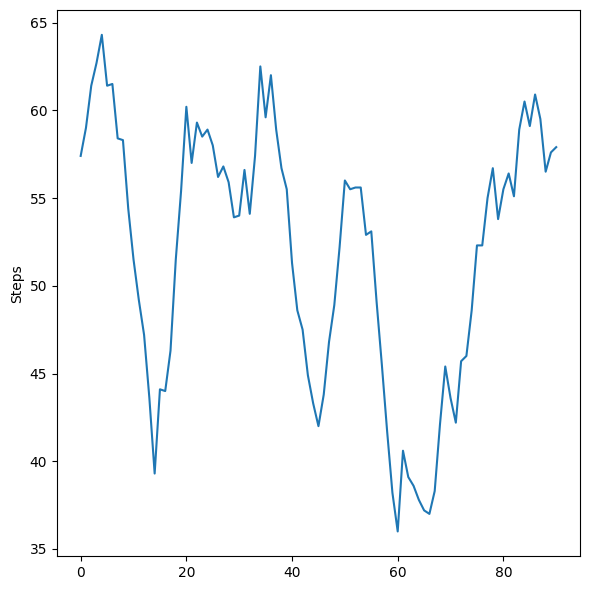

In [243]:

%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
window_size = 10

steps = np.convolve(train_hist["steps"],  np.ones(window_size)/window_size, mode='valid')

# Plot rewards
ax1.plot(steps)
ax1.set_ylabel('Steps')

plt.tight_layout()
plt.show()


[]

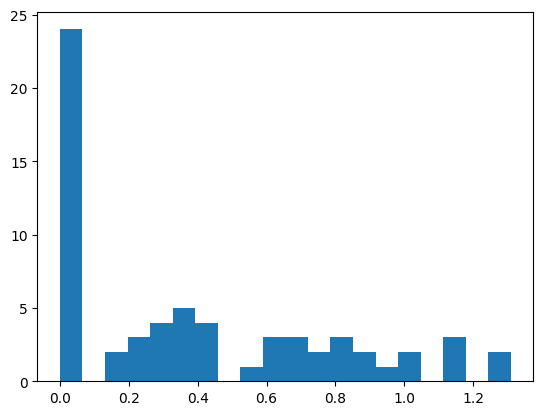

In [244]:
%matplotlib inline
polar_mat = sailor.polar

speeds = []
for key in polar_mat.keys():
    speeds.append(np.mean(polar_mat[key]))

fig, ax = plt.subplots()
ax.hist(speeds,bins=20)
plt.plot()
    

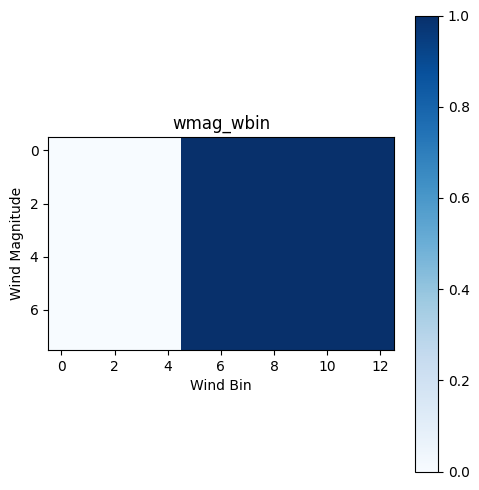

In [246]:
%matplotlib inline
polar_mat = sailor.polar

angles = []
wmag = []


for key in polar_mat.keys():
    angle, wind_mag = key
    angles.append(angle)
    wmag.append(wind_mag)


angle_wmag = np.zeros((max(angles)+1, max(wmag)+1))

for key in polar_mat.keys():
    angle, wind_mag = key
    angle_wmag[angle][wind_mag] += 1
    

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes = [axes]

# Affichage de la matrice wmag_wbin
im0 = axes[0].imshow((angle_wmag), cmap='Blues')
axes[0].set_title('wmag_wbin')
axes[0].set_xlabel('Wind Bin')
axes[0].set_ylabel('Wind Magnitude')
fig.colorbar(im0, ax=axes[0])

# Affichage de la figure
plt.tight_layout()
plt.show()
    

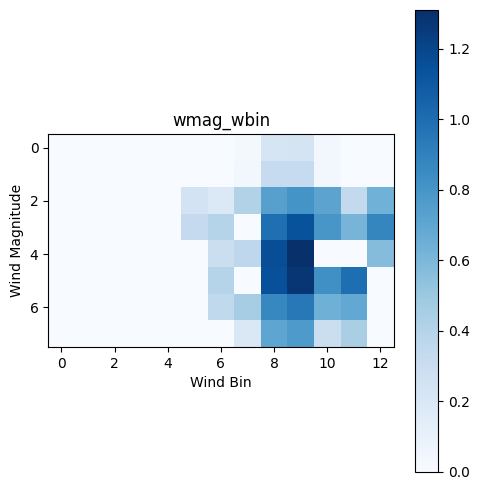

In [247]:
%matplotlib inline
polar_mat = sailor.polar

angles = []
wmag = []

dico = {}

for key in polar_mat.keys():
    angle, wind_mag = key
    angles.append(angle)
    wmag.append(wind_mag)

    dico.setdefault(key, [])
    dico[key].extend(polar_mat[key])

angle_wmag = np.zeros((max(angles)+1, max(wmag)+1))

for key in polar_mat.keys():
    angle, wind_mag = key
    angle_wmag[angle][wind_mag] = np.mean(dico[key])
    

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes = [axes]

# Affichage de la matrice wmag_wbin
im0 = axes[0].imshow((angle_wmag), cmap='Blues')
axes[0].set_title('wmag_wbin')
axes[0].set_xlabel('Wind Bin')
axes[0].set_ylabel('Wind Magnitude')
fig.colorbar(im0, ax=axes[0])

# Affichage de la figure
plt.tight_layout()
plt.show()

In [248]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
%matplotlib notebook

test_agent = MyNaiveAgent()
n = np.random.randint(0, 100000)
i = np.random.randint(1,4)
results_steps, results_rew, results_avg_speed = test(sailor, num_test=1, max_steps=500, seed=[n], env=i, verbose=False)
results_steps2, results_rew2, results_avg_speed2 = test(test_agent, num_test=1, max_steps=500, seed=[n], env=i, verbose=False)


coordinates = sailor.hist_pos
x_data = []
y_data = []
actions = sailor.hist_actions

for x, y in coordinates:
    x_data.append(x)
    y_data.append(y)

coordinates2 = test_agent.hist_pos
x_data2 = []
y_data2 = []
actions2 = test_agent.hist_actions

for x, y in coordinates2:
    x_data2.append(x)
    y_data2.append(y)

# Initialisation de la figure et des axes
fig, ax = plt.subplots()
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
line, = ax.plot([], [], 'b-', lw=2)  # 'b-' signifie une ligne bleue
line2, = ax.plot([], [], 'r-', lw=2)
title = ax.set_title("Steps")


# Initialisation de la ligne
def init():
    line.set_data([], [])
    return line,

# Fonction d'animation
def animate(i):
    x = x_data[:i]
    y = y_data[:i]
    line.set_data(x, y)
    x2 = x_data2[:i]
    y2 = y_data2[:i]
    line2.set_data(x2, y2)
    title.set_text(f"Steps - {i} - Action - {actions[i]}")
    return line, line2,

# Création de l'animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(coordinates), interval=100, blit=True)

# Affichage de l'animation dans un notebook Jupyter
HTML(ani.to_jshtml())

------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 1 new episodes...
exploration rate re-set to : 0.3
------ END OF TEST ----------------------------------                                
------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 1 new episodes...
exploration rate re-set to : 0
------ END OF TEST ----------------------------------                                


<IPython.core.display.Javascript object>

------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 21 new episodes...
exploration rate re-set to : 0#]
------ END OF TEST ----------------------------------                                
------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 21 new episodes...
exploration rate re-set to : 0#]
------ END OF TEST ----------------------------------                                
------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 21 new episodes...
exploration rate re-set to : 0#]
------ END OF TEST ----------------------------------                                
------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 21 new episode

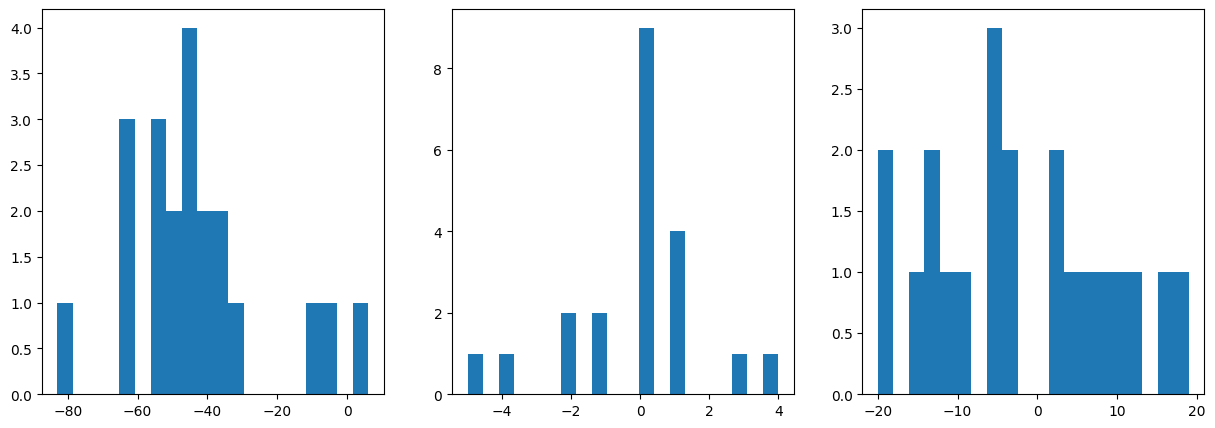

In [233]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_agent = MyNaiveAgent()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

verbose = True

num_test = 21
n = [random.randint(0, 200000) for _ in range(num_test)]

for i in range(1,4):
    results_steps, results_rew, results_avg_speed = test(sailor, num_test=num_test, max_steps=500, seed=n, env=i, verbose=verbose)
    results_steps2, results_rew2, results_avg_speed2 = test(test_agent, num_test=num_test, max_steps=500, seed=n, env=i, verbose=verbose)

    delta = []
    for s1, s2 in zip(results_steps, results_steps2):
        delta.append(s1 - s2)

    axes[i-1].hist(delta,bins=20)

plt.show()

In [321]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
%matplotlib notebook

n = np.random.randint(0, 100000)
i = np.random.randint(1,4)

##### PARAMETERS OF TRAINING #####
num_episodes = 1
max_steps = 1000  

### Create environment with a simple initial windfield ###
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

### BOOK KEEPING
train_hist = {
    "episode": [],
    "rewards": [],
    "steps": [],
    "success": [],
    "environnement": [],
    "exploration": []
    }

start_time = time.time()
phase = 0

# CHOSE ENVIRONEMENT FOR EPISODE
env = dico_env[i]

sailor.clear_history()
sailor.reset()

best_courses = []

# INITIAL ENVIRONNEMENT
observation, info = env.reset(seed=sailor.training_session)
state = sailor.discretize_state(observation)

for step in range(max_steps):

    explored, positions, course, distance = sailor.get_best_course(observation=observation)
    
    best_courses.append(positions)
    # Select action and take step
    action = sailor.act(observation)
    next_observation, reward, done, truncated, info = env.step(action)


    observation = next_observation
    total_reward += reward

    # Break if episode is done
    if done or truncated:
        break
    

coordinates = sailor.hist_pos
x_data = []
y_data = []

for x, y in coordinates:
    x_data.append(x)
    y_data.append(y)


# Initialisation de la figure et des axes
fig, ax = plt.subplots()
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
line, = ax.plot([], [], 'b-', lw=2)  # 'b-' signifie une ligne bleue
line2, = ax.plot([], [], 'r-', lw=2)
title = ax.set_title("Steps")


# Initialisation de la ligne
def init():
    line.set_data([], [])
    return line,

# Fonction d'animation
def animate(i):
    x = x_data[:i]
    y = y_data[:i]
    line.set_data(x, y)
    course = best_courses[i]
    x2 = [x for x, y in course]
    y2 = [y for x, y in course]
    line2.set_data(x2, y2)
    title.set_text(f"Steps - {i} - Action - {actions[i]}")
    return line, line2,

# Création de l'animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(coordinates), interval=100, blit=True)

# Affichage de l'animation dans un notebook Jupyter
HTML(ani.to_jshtml())
        


Begin finding courses
Step: 1, Distance: 30.29770104090373, Best Course: 1
Step: 2, Distance: 29.595402081807453, Best Course: 2
Step: 3, Distance: 28.89310312271118, Best Course: 3
Step: 4, Distance: 28.293724111913342, Best Course: 4
Step: 5, Distance: 27.591590284461702, Best Course: 5
Step: 6, Distance: 26.889465081812833, Best Course: 6
Step: 7, Distance: 26.304696230295818, Best Course: 7
Step: 8, Distance: 25.735171507591907, Best Course: 8
Step: 9, Distance: 25.18192523730316, Best Course: 9
Step: 10, Distance: 24.482979418201154, Best Course: 10
Step: 11, Distance: 23.949235555061264, Best Course: 11
Step: 12, Distance: 23.434670544440856, Best Course: 12
Step: 13, Distance: 22.94057498747756, Best Course: 13
Step: 14, Distance: 22.468299342865325, Best Course: 14
Step: 15, Distance: 22.019247656085973, Best Course: 15
Step: 16, Distance: 21.59486875844391, Best Course: 16
Step: 17, Distance: 21.19664462653724, Best Course: 17
Step: 18, Distance: 20.82607566316629, Best Course

KeyboardInterrupt: 

In [118]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sailor,
    output_path="agents/capitaine_2.py",
    agent_class_name="Capitaine_2"
)

Agent saved to agents/capitaine_2.py
The file contains 5802 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb
